<a href="https://colab.research.google.com/github/fudw/dice_detection_for_board_games/blob/main/dice_detection_yolov5_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# download dataset from https://public.roboflow.com/object-detection/dice/
!wget https://public.roboflow.com/ds/VdKh306UT4?key=4OgEXgYGDp
!unzip /content/VdKh306UT4?key=4OgEXgYGDp

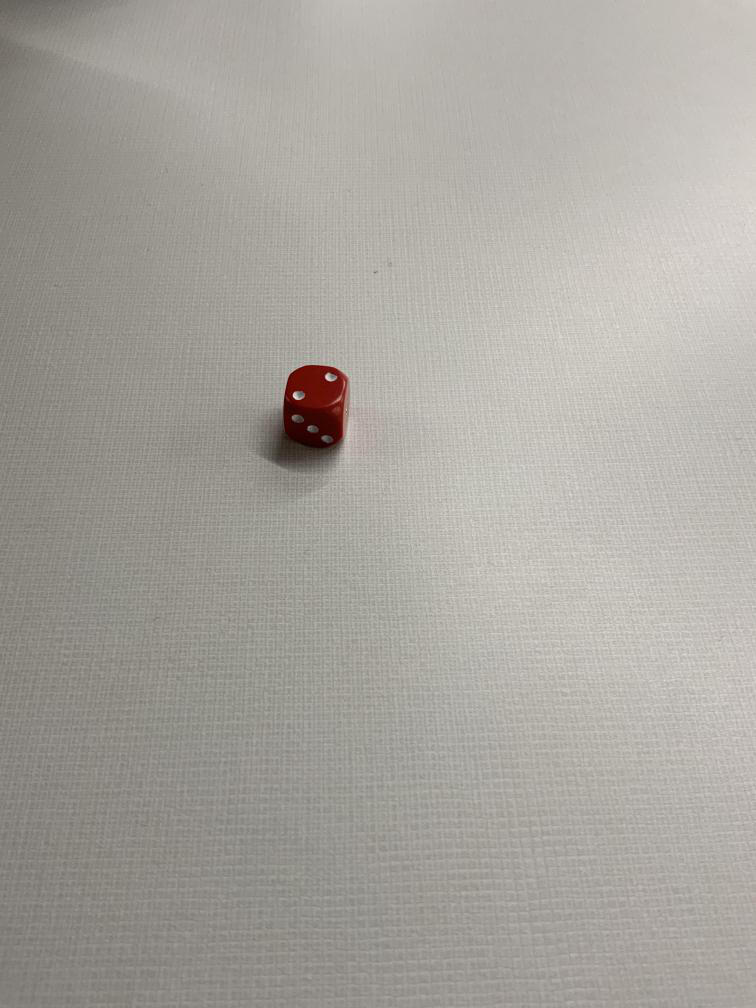

In [ ]:
from PIL import Image

# take a look at an image
Image.open('/content/export/images/0BrzNN9qMnzQlQPZ1sso.jpg')

In [46]:
# import ALL the things
import os
import numpy as np
import pandas as pd
import random
import torch
import torchvision
from torchvision import transforms as T
import cv2
import yaml

seed = 42
random.seed(seed)

In [ ]:
os.listdir()

['.config',
 'README.roboflow.txt',
 'VdKh306UT4?key=4OgEXgYGDp',
 'README.dataset.txt',
 'export',
 'data.yaml',
 'sample_data']

In [ ]:
os.rename('dice_data', 'export')

In [ ]:
os.rename('export', 'dice_dataset')
root = os.path.abspath('dice_data')
image_dir = os.path.join(root, 'images')
label_dir = os.path.join(root, 'labels')

In [ ]:
image_names = list(sorted(os.listdir(image_dir)))
label_names = list(sorted(os.listdir(label_dir)))

In [ ]:
print(label_names)

['0BrzNN9qMnzQlQPZ1sso.txt', '0kpaB4UeoohBVODkOmGd.txt', '0thII0LnXrzeDTZ6HbiS.txt', '1W3kCdCcSnq0jkQiZZ00.txt', '1XPc36ZuLHMLotkAKZfP.txt', '1YO2nsEEBcYqrlqAjWnN.txt', '1bq71k3UzSwfjl92NWoE.txt', '1dRQgfot47CoYg4LXtcM.txt', '1dtjooCYlexEbdq5MFnj.txt', '1obZeGiMS68DhdoK1fE8.txt', '28xg7NE6BFiIG00ntjUj.txt', '2Jdc4WkHh9HYffuZeHnQ.txt', '2Wyy0t12ncx6iSU9TLYY.txt', '2b8Pg6CIBTv9ENExsdHj.txt', '2cvr7g3s05VHPioOgDU0.txt', '2tBgEoN8m2tkfArf5WxK.txt', '2tGrB7B3Uu5vBHiezJX6.txt', '38HYTY0rI2GiEkyN1HmB.txt', '3O659AL0r3CVndX9Lj2P.txt', '3SaaOzF1tTiQifxHmHYH.txt', '3T85dp6ZMfWoAqsVYbOZ.txt', '4DARx0NxPQLclN9yd8CB.txt', '4GFi9SMMq5zXYRpalRfh.txt', '4MzDILAWSe33JKJ78VIS.txt', '4kfY1a5pPXQ7TfcMAwXa.txt', '4mWLfLTZ0iAl0CRaWgnZ.txt', '4vCbLxjFV6O7TZhzcCAO.txt', '52sGXFvnXjfFfUpgmrVP.txt', '57iAfEeq46YERKcU29LF.txt', '5NIJrjmnp8SHRnfSC40M.txt', '5eKFklZ8VDJS5kUy72Eh.txt', '5jGcX2cBrgSsKeCkoDse.txt', '5kXKt6hnCJQNUOxT1DkR.txt', '62CzEm7HrnXOIquNxVJq.txt', '6Ni05IeZkaX9MQIBEUi5.txt', '6S1A4XS9bWOy9H7flr

In [ ]:
print(len(image_paths))

718


In [51]:
train_val_split = 0.9
train_names = sorted(random.sample(image_names, int(len(image_names) * train_val_split)))
val_names = sorted(list(set(image_names) - set(train_names)))
print(f'training set has {len(train_names)} images')
print(f'validation set has {len(val_names)} images')

training set has 646 images
validation set has 72 images


In [ ]:
print(image_paths[0][:-4])

0BrzNN9qMnzQlQPZ1sso


In [ ]:
label_file = os.path.join(label_dir, label_names[0])
with open(label_file, 'r') as file:
  targets = file.read()
targets = targets.split('\n')
targets

['1 0.4174933862433862 0.3835565476190476 0.08167989417989419 0.043402777777777776']

In [ ]:
col = ['name', 'class', 'centre_x', 'centre_y', 'width', 'height']
image_df = pd.DataFrame(columns = col)
image_df

,name,class,centre_x,centre_y,width,height


In [ ]:
row = {}
row[col[0]] = label_names[0][:-4]
for i, t in enumerate(targets[0].split(' ')):
  row[col[i+1]] = float(t)
row

{'centre_x': 0.4174933862433862,
 'centre_y': 0.3835565476190476,
 'class': 1.0,
 'height': 0.043402777777777776,
 'name': '0BrzNN9qMnzQlQPZ1sso',
 'width': 0.08167989417989419}

In [ ]:
image_df.append(row, ignore_index = True)

,name,class,centre_x,centre_y,width,height
0,0BrzNN9qMnzQlQPZ1sso,1.0,0.417493,0.383557,0.08168,0.043403


In [ ]:
image_df

,name,class,centre_x,centre_y,width,height


In [ ]:
def get_targets(label_name):
  
  label_file = os.path.join(label_dir, label_name)
  with open(label_file, 'r') as file:
    targets = file.read()
  
  return targets.split('\n')

def get_row(label_name, targets, col):
  
  row = {}
  row[col[0]] = label_name[:-4]
  for i, t in enumerate(targets.split(' ')):
    row[col[i+1]] = float(t)
  
  return row

def add_targets_to_df(df, label_name):
  
  targets = get_targets(label_name)
  for target in targets:
    row = get_row(label_name, target, df.columns)
    df = df.append(row, ignore_index = True)
  
  return df

def create_image_df_with_labels(col, label_names):
  
  df = pd.DataFrame(columns = col)
  for name in label_names:
    df = add_targets_to_df(df, name)
  
  return df


In [ ]:
final_df = create_image_df_with_labels(col, label_names)
final_df

,name,class,centre_x,centre_y,width,height
0,0BrzNN9qMnzQlQPZ1sso,1.0,0.417493,0.383557,0.081680,0.043403
1,0kpaB4UeoohBVODkOmGd,3.0,0.389385,0.640625,0.034061,0.023313
2,0kpaB4UeoohBVODkOmGd,5.0,0.675430,0.340278,0.024802,0.014385
3,0thII0LnXrzeDTZ6HbiS,3.0,0.528935,0.426711,0.081680,0.045387
4,1W3kCdCcSnq0jkQiZZ00,5.0,0.537822,0.501157,0.019593,0.029431
5,1W3kCdCcSnq0jkQiZZ00,5.0,0.503100,0.429729,0.018601,0.027447
6,1XPc36ZuLHMLotkAKZfP,0.0,0.499173,0.436384,0.088955,0.052827
7,1YO2nsEEBcYqrlqAjWnN,2.0,0.654927,0.430680,0.024140,0.013641
8,1YO2nsEEBcYqrlqAjWnN,2.0,0.531911,0.605159,0.031415,0.019345
9,1bq71k3UzSwfjl92NWoE,3.0,0.499504,0.398934,0.084987,0.051835


In [ ]:
def get_label_and_boxes(image_name, df):

  rows = df[df.name == image_name[:-4]]

  return rows['class'].values, rows[box_cols].values

In [ ]:
box_cols = col[-4:]
box_cols

['centre_x', 'centre_y', 'width', 'height']

In [ ]:
class dice_pretrain_dataset(torch.utils.data.Dataset):

  def __init__(self, root, image_names, df, transforms = None):

    super().__init__()
    self.root = root
    self.image_names = image_names
    self.df = df
    self.transforms = transforms

  def __len__(self):

    return len(self.image_names)

  def __getitem__(self, idx):

    image_name = self.image_names[idx]
    image_path = os.path.join(image_dir, image_name)
    